In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import itertools
from typing import Tuple
from pprint import pprint
import json

This project can be split into a couple of distinct steps:

0. Preparation
1. Generate all possible states
2. Fill in the Q-Table for the perfect opponent
3. Fill in the Q-Table for a random opponent
4. Create "Play the game" function
5. Perform Machine Learning
6. Play around with machine learning

**Part 0: Preparation**<br>
Building a validity checker<br>
Building a determining function<br>

<h3>012</h3>
<h3>345</h3>
<h3>678</h3>

In [53]:
def check_validity(state: str) -> bool: 
    """checks if a state is valid"""

    x_number = state.count('x')
    o_number = state.count('o')
    empty_number = state.count('_')
    #There should be at most 1 more x then o
    if (x_number < o_number) or (x_number - 1 > o_number):
        return False
    
    if (x_number + o_number + empty_number) != 9:
        return False

    #There can at most be one win
    x_win = False
    o_win = False

    #check diagonals
    if ((state[0] + state[4] + state[8]) == "ooo") or ((state[6] + state[4] + state[2]) == "ooo"):
        o_win = True
    elif ((state[0] + state[4] + state[8]) == "xxx") or ((state[6] + state[4] + state[2]) == "xxx"):
        x_win = True  


    #Check rows and cols
    for i in range(3):
        if (state[3 * i] + state[3 * i + 1] + state[3 * i + 2] == "xxx") or ((state[i] + state[3 + i] + state[6 + i] == "xxx")):
            x_win = True
        if (state[3 * i] + state[3 * i + 1] + state[3 * i + 2] == "ooo") or ((state[i] + state[3 + i] + state[6 + i] == "ooo")):
            o_win = True

    #if two players won, that's impossible
    if x_win and o_win:
        return False
    if x_win and (x_number == o_number):
        return False
    if o_win and (x_number > o_number):
        return False
    
    return True

def check_result(state: str) -> int:
    #check diagonals
    if ((state[0] + state[4] + state[8]) == "ooo") or ((state[6] + state[4] + state[2]) == "ooo"):
        return -1
    elif ((state[0] + state[4] + state[8]) == "xxx") or ((state[6] + state[4] + state[2]) == "xxx"):
        return 1
    #Check rows and cols
    for i in range(3):
        if (state[3 * i] + state[3 * i + 1] + state[3 * i + 2] == "xxx") or ((state[i] + state[3 + i] + state[6 + i] == "xxx")):
            return 1
        if (state[3 * i] + state[3 * i + 1] + state[3 * i + 2] == "ooo") or ((state[i] + state[3 + i] + state[6 + i] == "ooo")):
            return -1
    
    if state.count('_'):
        return 2

    return 0

def display_state(state: str):
    """displays the state"""
    print(state[0] + state[1] + state[2])
    print(state[3] + state[4] + state[5])
    print(state[6] + state[7] + state[8])

**Step 1 & 2: Generate all possible states & Fill in the Q-Table for the perfect opponent**<br>
Find all possible permutations of the final state<br>
For each permutation, remove a char and add to the Q-Table<br>
Fill in the Q-Table as I go<br>

In [54]:
def make_list(x):
    return np.zeros(9)

def drop_char(state: str, move_number: int) -> list:
    """Takes in a state and return all the possible states that could have lead to it"""
    possible_states = list()

    #find out who's marker to remove
    player_marker = 'x' 
    if move_number % 2 == 0:
        player_marker = 'o'

    #go through each char and see if it needs to be removed
    list_state = list(state)
    for i, char in enumerate(list_state):
        if char == player_marker:
            list_state[i] = '_'
            possible_states.append(''.join(list_state))
            list_state[i] = player_marker

    return possible_states

def generate_Q_Table_perfect_opponent() -> pd.DataFrame:
    """Generates a Q-Table against a perfect opponent
    Starts by finding all the end states and removes chars to create lower states
    Uses a pandas data frame for optimal speed"""

    Q_table = pd.DataFrame(columns=['state', 'action', 'move number'])
    
    #Generate the final states
    chars = ['x'] * 5 + ['o'] * 4
    perms = pd.Series(list({''.join(p) for p in itertools.permutations(chars)}))
    perms = perms[perms.apply(check_validity) == True]

    #Append the final states to the Q_Table
    perms = perms.reset_index(drop=True) # pyright: ignore[reportAttributeAccessIssue]
    perms = pd.DataFrame({'state': perms, 'action': 0,'move number': 9})
    Q_table = pd.concat([Q_table, perms], ignore_index=True)
    Q_table['action'] = Q_table['state'].map(make_list)
    
    #Now it is necessary to go through every single final state and drop a char
    #for move_number in range(8, -1, -1):
        #for state in Q_table[Q_table['move number'] == move_number + 1]['state']:
             



    #Then all the necessary possitions to the Q-Table
    return Q_table

generate_Q_Table_perfect_opponent()

,state,action,move number
0,ooxxxxoox,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",9
1,xxxoxoxoo,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",9
2,oxxxoooxx,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",9
3,xooxxxoox,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",9
4,xxxooxxoo,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",9
...,...,...,...
73,xxoxoxxoo,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",9
74,xooxxooxx,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",9
75,oxxxooxox,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",9
76,ooxxooxxx,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",9




Let's do some logic.

Let's say that I have an empty Q-Table. Like legit a COMPLETELY RMPTY ONE

Now...... if I play against a random opponent.....

If I make moves and I end up winning, all those positions are deemed as good positions.

If I make moves and draw, those positions are neutral.

If I make moves and loose, all those positions are deemed wortheless and should be avoided.



for example say this was the game: <br>
___  __x  _ox  _ox  _ox  _ox <br>
___  ___  ___  _x_  _xo  _xo <br>
___  ___  ___  ___  ___  xoo <br>

each position where it's the turn of x:
x should be uplifted.
Like for example

_________ should have an increase in the value 2 etc. All the positions and the values which they resulted in, then we cook. Cause then all those positions are prioritised.

Step 1:
Import Data Set

Step 2:
Create a dead empty Q-Table

Step 3:
Create a function which prioritises better positions.

Step 4:
Write the function which can play the game once, store all the positions and moves which lead to them.

In [55]:



#Step 1 & 2:
Q_Table_read = pd.read_csv("list_of_all_possible_states.csv")



Q_Table = dict()

for state in Q_Table_read['state']:
    Q_Table[state] = np.zeros(9)


In [56]:
#Slighty modifying Q_table
with open("perfect_Q_Table.json", "r", encoding="utf-8") as f:
    perfect_Q_Table = json.load(f)

def change_to_numpy(actions):
    """Changes a normal list to a numpy array"""
    actions = np.array(actions, dtype=float)
    return np.array(actions)

perfect_Q_Table = {state: change_to_numpy(action) for state, action in perfect_Q_Table.items()}

In [57]:
#Helper Functions
def return_valid_moves(state: str):
    """returns an array where 
    1 => possible to make a move
    0 => square is taken"""
    possible_moves = np.zeros(9)
    for i, move in enumerate(state):
        if move == '_':
            possible_moves[i] = 1
    
    return possible_moves

def pick_learning_move(Q_Table: dict, state:str, tau=np.e, player='x') -> int:
    """This function a move from a list of all possible moves
    Prioritising the onces with more favourable entries"""
    
    valid_moves = return_valid_moves(state)

    player_multiplier = 1 #if 'o', let it be -1
    if player == 'o':
        player_multiplier = 1

    weights = np.power(tau, player_multiplier * Q_Table[state]) * valid_moves
    pick = np.random.choice(range(9), p=weights/weights.sum())

    return pick

def pick_random_move(state: str) -> int:
    """This functions picks any random move in the game"""

    weights = return_valid_moves(state)
    pick = np.random.choice(range(9), p=weights/weights.sum())
    return pick


def pick_perfect_move(perfect_Q_Table: dict, state: str, player='x'):
    """This picks a random best possible move"""
    desired_move = np.nanmax(perfect_Q_Table[state])

    if player == 'o':
        desired_move = np.nanmin(perfect_Q_Table[state])

    possible_indices = []

    for i, move in enumerate(perfect_Q_Table[state]):
        if move == desired_move:
            possible_indices.append(i)

    return random.choice(possible_indices)


def update_board(state:str, action, player='x') -> str:
    """returns a string which is the updated board"""
    state_list = list(state)
    state_list[action] = player
    state = ''.join(state_list)
    return state

def pick_maximum(Q_Table: dict, state: str):
    """finds the what is the best possible result you can achieve"""
    maximum = -1
    valid_moves = return_valid_moves(state)

    for i in range(9):
        if valid_moves[i] == 1:

            if Q_Table[state][i] > maximum:
                maximum = max(maximum, Q_Table[state][i])

    
    return maximum

def pick_minimum(Q_table: dict, state: str):
    """finds the what is the worst possible result you can achieve"""
    minimum = 1
    valid_moves = return_valid_moves(state)

    for i in range(9):
        if valid_moves[i] == 1:

            if Q_Table[state][i] > minimum:
                minimum = min(minimum, Q_Table[state][i])

    
    return minimum

def learn_from_qeue(Q_Table, qeue, alpha=0.1, player='x'):
    """Updates the Q_Table based on the past games"""


    for game, result in qeue: #goes through ever game in the qeue

        for move_number, (state, action) in enumerate(game): #go through each state and action taken in the game

            if (move_number + 1) == len(game):
                if player == 'o':
                    result = -result

                Q_Table[state][action] += alpha * (result - Q_Table[state][action]) #If the game is terminated, the give immidiate reward as a resut

            else: 

                next_state = game[move_number + 1][0] #next state
                if player == 'x':
                    Q_Table[state][action] += alpha * (pick_maximum(Q_Table, next_state) - Q_Table[state][action]) # x aims to have most positive winning chances
                if player == 'o':
                    Q_Table[state][action] += alpha * (pick_maximum(Q_Table, next_state) - Q_Table[state][action]) # o aims to have most negative entries

def display_counter(counter):
    total = sum(counter) / 100
    print(f"{counter[0]/total:.2f}%   {counter[1]/total:.2f}%   {counter[2]/total:.2f}%")

def calculate_tau(turn) -> float:
    """returns tau
    Higher tau means the moves deemed good are more likely to be chosen"""
    
    tau = 1 + 2 * turn/100
    
    return float(tau)

def calculate_alpha(turn) -> float:
    """returns tau
    Higher tau means the moves deemed good are more likely to be chosen"""
    
    alpha = 0.1#max(0.0001, 0.1 * np.exp(-0.0001 * turn))
    return float(alpha)



In [58]:
#Functions related to playing the game

def play_the_game_learning(Q_Table, tau=np.e, player='x', perfect_opponent=False, perfect_Q_Table=dict()):
    """Playes the game and returns a qeue of tuples"""
    queue = []
    state = "_________"
    move_number = 0
    result = 2
    player_index = 0
    oppostion = 'o'


    if player == 'o':
        player_index = 1
        oppostion = 'x'

    while result == 2: #While the game is still going
        if (move_number % 2) == player_index: #If it's the turn of the learning player
            action = pick_learning_move(Q_Table, state, tau, player) #Play a learned move
            queue.append((state, action)) #Record the move
            state = update_board(state, int(action), player) #Update board

        else:
            if perfect_opponent:
                action = pick_perfect_move(perfect_Q_Table, state, oppostion)
            else:
                action = pick_random_move(state) #Or, just play a random move
            state = update_board(state, action, oppostion) #Update board

        move_number += 1

        result = check_result(state)
    return queue, result

def play_the_game_random(Q_Table, player='x'):
    """Playes the randomly from both sides game and returns a qeue of tuples"""
    state = "_________"
    move_number = 0
    result = 2
    player_index = 0
    oppostion = 'o'


    if player == 'o':
        player_index = 1
        oppostion = 'x'

    while result == 2: #While the game is still going
        if (move_number % 2) == player_index: #If it's the turn of the learning player
            action = pick_random_move(state) #Or, just play a random move
            state = update_board(state, action, player) #Update board

        else:
            action = pick_random_move(state) #Or, just play a random move
            state = update_board(state, action, oppostion) #Update board

        move_number += 1

        result = check_result(state)
    return result


In [59]:
counter_final_values = [] #list of how well the bot is performing

In [63]:
counter = [0, 0, 0]

player='o'

BATCH_SIZE = 10
NUMBER_OF_BATCHES = 10000


    

for batch_number in range(1, NUMBER_OF_BATCHES): #this many batches
    game_qeue = []

    tau = calculate_tau(batch_number * BATCH_SIZE)
    for game_number in range(BATCH_SIZE): #each batch is 10 games long
        
        qeue, result = play_the_game_learning(Q_Table,tau,  player, True, perfect_Q_Table) #plays the games
        counter[result + 1] += 1 #updates the result
        game_qeue.append((qeue, result))

    alpha = calculate_alpha(batch_number * BATCH_SIZE)
    learn_from_qeue(Q_Table, game_qeue, alpha, player) #updates the q_table


    if batch_number % 100 == 0: #every hundred values, displays score
        counter_final_values.append(counter)
        print(int(batch_number/100))
        display_counter(counter)
        counter = [0, 0, 0]

    





1
0.00%   23.90%   76.10%
2
0.00%   48.40%   51.60%
3
0.00%   56.80%   43.20%
4
0.00%   65.30%   34.70%
5
0.00%   67.20%   32.80%
6
0.00%   71.20%   28.80%
7
0.00%   73.00%   27.00%
8
0.00%   75.10%   24.90%
9
0.00%   74.70%   25.30%
10
0.00%   80.20%   19.80%
11
0.00%   79.50%   20.50%
12
0.00%   80.30%   19.70%
13
0.00%   82.80%   17.20%
14
0.00%   84.00%   16.00%
15
0.00%   84.70%   15.30%
16
0.00%   83.70%   16.30%
17
0.00%   86.50%   13.50%
18
0.00%   86.30%   13.70%
19
0.00%   86.30%   13.70%
20
0.00%   86.70%   13.30%
21
0.00%   88.90%   11.10%
22
0.00%   88.80%   11.20%
23
0.00%   88.70%   11.30%
24
0.00%   89.70%   10.30%
25
0.00%   89.60%   10.40%
26
0.00%   89.70%   10.30%
27
0.00%   90.80%   9.20%
28
0.00%   89.60%   10.40%
29
0.00%   88.70%   11.30%
30
0.00%   89.50%   10.50%
31
0.00%   90.80%   9.20%
32
0.00%   91.30%   8.70%
33
0.00%   91.70%   8.30%
34
0.00%   92.60%   7.40%
35
0.00%   93.10%   6.90%
36
0.00%   92.40%   7.60%
37
0.00%   93.50%   6.50%
38
0.00%   93.00% 

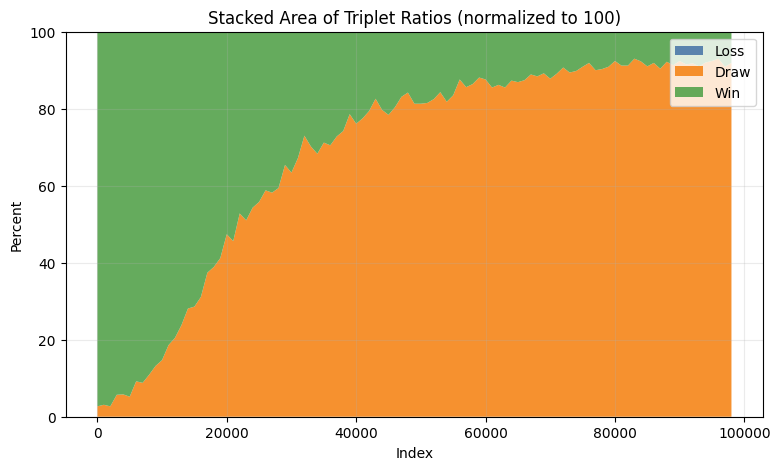

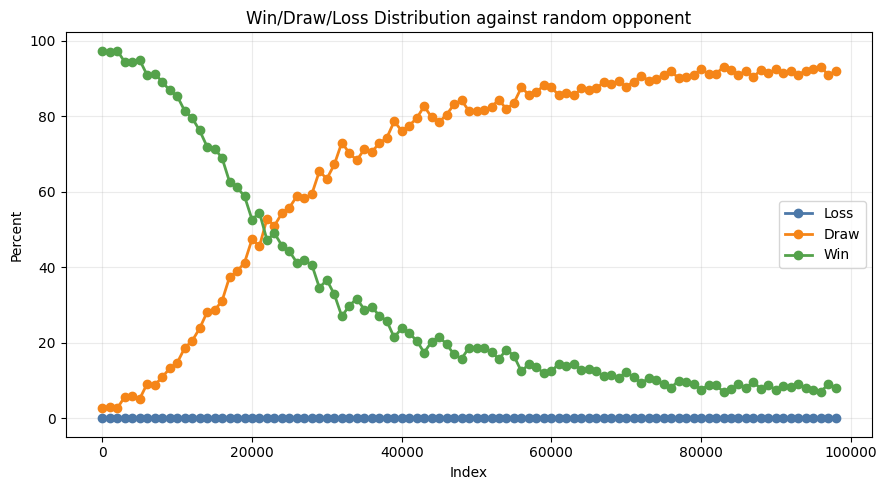

In [61]:

def plot_triplet_ratios(data, component_labels=("A", "B", "C"), normalize=True, show=True):
    """
    Plot a list of 3-element lists (triplets) that (roughly) sum to 100.
    Produces two plots:
      1) Stacked area chart (normalized to 100 if requested)
      2) Line chart of each component over index

    Parameters
    ----------
    data : list[list[float]]
        Sequence of triplets, e.g. [[20, 40, 40], [10, 40, 50], [8, 38, 54], ...]
    component_labels : tuple[str, str, str]
        Names for the three components.
    normalize : bool
        If True, each triplet is scaled so its sum is exactly 100.
        If False, values are plotted as-is.
    show : bool
        If True, calls plt.show() at the end.
    """
    # Validate input
    arr = np.array(data, dtype=float)
    if arr.ndim != 2 or arr.shape[1] != 3:
        raise ValueError("`data` must be a 2D array-like with shape (n_samples, 3).")

    # Optionally normalize each row to sum to 100
    if normalize:
        row_sums = arr.sum(axis=1)
        # Avoid division by zero; keep rows with sum==0 as zeros
        with np.errstate(divide='ignore', invalid='ignore'):
            scale = np.where(row_sums == 0, 0, 100.0 / row_sums)
        arr = (arr.T * scale).T

    # Split components
    comp1, comp2, comp3 = arr.T
    x = np.arange(len(arr))* BATCH_SIZE * 100  # index (could be time or sample order)

    # --- Plot 1: Stacked area (stackplot) ---
    fig1, ax1 = plt.subplots(figsize=(9, 5))
    colors = ["#4C78A8", "#F58518", "#54A24B"]  # pleasant color palette
    ax1.stackplot(x, comp1, comp2, comp3, labels=component_labels, colors=colors, alpha=0.9)
    ax1.set_title("Stacked Area of Triplet Ratios" + (" (normalized to 100)" if normalize else ""))
    ax1.set_xlabel("Index")
    ax1.set_ylabel("Percent")
    ax1.set_ylim(0, max(100, arr.sum(axis=1).max()))  # ensure room if not normalized
    ax1.legend(loc="upper right")
    ax1.grid(True, alpha=0.25)

    # --- Plot 2: Line chart for each component ---
    fig2, ax2 = plt.subplots(figsize=(9, 5))
    ax2.plot(x, comp1, label=component_labels[0], color=colors[0], marker="o", linewidth=2)
    ax2.plot(x, comp2, label=component_labels[1], color=colors[1], marker="o", linewidth=2)
    ax2.plot(x, comp3, label=component_labels[2], color=colors[2], marker="o", linewidth=2)
    ax2.set_title("Win/Draw/Loss Distribution against random opponent" if normalize else "")
    ax2.set_xlabel("Index")
    ax2.set_ylabel("Percent")
    ax2.legend(loc="best")
    ax2.grid(True, alpha=0.25)

    plt.tight_layout()
    if show:
        plt.show()
plot_triplet_ratios(counter_final_values, component_labels=("Loss", "Draw", "Win"), normalize=True)

In [62]:
queue = play_the_game_learning(Q_Table, 2, 'x')
for state, action in queue [0]:
    display_state(state)
    print('\n')
print(queue[1])

___
___
___


___
_xo
___


___
_xo
o_x


_xo
_xo
o_x


1
